# Advanced Lane Lines - Perspective transformation

In this notebook the following points from the Project 4 Advanced Lane Lines are implemented:
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center. 
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 

---
## Step 0: Import required libraries 

In [10]:
import cv2
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

from camera_calibration import undistortImage, calibrateCamera
from color_gradient import imageTransformation
from perspective_transformation import getPerspectiveTransform, warpImage2birdsEyeView, pipelineImageTransformation


## Step 1:  Lane class definition

In [11]:
# Define a class to receive the characteristics of each line detection
class Line:
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False                
        
        # polynomial coefficients for the most recent fit
        self.currentFit = None
        
        # Buffer of n last fits
        self.deqBufferFit = collections.deque(maxlen=20)
        
        # difference in fit coefficients between last and new fits
        self.differenceFit = None #np.array([0,0,0], dtype='float') 
                
        # polynomial coefficients averaged over the last n iterations
        self.averageFit = None  
        
        # radius of curvature of the line in some units
        self.curvatureRadius = None 
        
    
    def updateLineFit(self, pixel_pos_x, pixel_pos_y):
        self.currentFit = np.polyfit(pixel_pos_y, pixel_pos_x, 2)
        
        if len(self.deqBufferFit)!=0:
            self.differenceFit = np.subtract(self.currentFit, self.deqBufferFit[len(self.deqBufferFit)-1])
            
        self.deqBufferFit.append(self.currentFit)
        self.averageFit = np.mean(self.deqBufferFit, axis=0)
        return
    
    def getFit(self, useAverageFit=False):
        if useAverageFit:
            return self.averageFit
        else:
            return self.currentFit
            
    def getXY(self, imgShapeY, useAverageFit=False):          
        ploty = np.linspace(0, imgShapeY -1, imgShapeY)
        if useAverageFit==True and self.averageFit is not None:
            fit = self.averageFit
        else:
            fit = self.currentFit
        
        fitx = fit[0] * ploty**2 + fit[1] * ploty + fit[2]
        return ploty, fitx
    
    def getLaneLineCurvature(self, configParams, imgShapeY):
    
        ploty = []
        ploty, fitx = self.getXY(imgShapeY, useAverageFit=True)
        yEval = np.max(ploty)

        yMeterPerPixel = configParams['y_meter_per_pixel']
        xMeterPerPixel = configParams['x_meter_per_pixel']

        # Fit polynomials to x,y in world space
        fit = np.polyfit(ploty * yMeterPerPixel, fitx * xMeterPerPixel, 2)

        # Calculate the new radii of curvature
        curvatureRadius = (((1 + (2 * fit[0] * yEval * yMeterPerPixel + fit[1])**2)**1.5) / 
                            np.absolute(2*fit[0]))

        return curvatureRadius

class window:
    def __init__(self, xLow, xHigh, yLow, yHigh):
        self.xLow = np.int32(xLow)
        self.xHigh = np.int32(xHigh)
        self.yLow = np.int32(yLow)
        self.yHigh = np.int32(yHigh)

In [12]:
def getLaneIndices(nonzeroIndices, windowLeft, windowRight):
    
    nonzeroy = np.array(nonzeroIndices[0])
    nonzerox = np.array(nonzeroIndices[1])
    
    leftLaneInds = ((nonzeroy >= windowLeft.yLow) & (nonzeroy < windowLeft.yHigh) & 
                      (nonzerox >= windowLeft.xLow) & (nonzerox < windowLeft.xHigh)).nonzero()[0]
    
    rightLaneInds = ((nonzeroy >= windowRight.yLow) & (nonzeroy < windowRight.yHigh) & 
                       (nonzerox >= windowRight.xLow) & (nonzerox < windowRight.xHigh)).nonzero()[0]
    
    return leftLaneInds, rightLaneInds
    
# Extract left and right line pixel positions
def getLanePixelPositions(nonzeroIndices, laneIndices):
    nonzeroy = np.array(nonzeroIndices[0])
    nonzerox = np.array(nonzeroIndices[1])
    
    x = nonzerox[laneIndices]
    y = nonzeroy[laneIndices] 
    
    return x, y

## Step 2:  Detect lane lines in an image 

In [13]:
def detectLaneLines(birdsEyeView, line_left, line_right, plotImage=False):
    
    out_img = (np.dstack((birdsEyeView, birdsEyeView, birdsEyeView))*255).astype(np.uint8)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdsEyeView[np.int(birdsEyeView.shape[0]/2):,:], axis=0)
    
    #print("histogram.shape = {}".format(histogram.shape))
    #print()        
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    n_windows = 9
    
    # Set height of windows
    window_height = np.int(birdsEyeView.shape[0]/n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdsEyeView.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for n_window in range(n_windows):
        
        # Identify window boundaries in x and y (and right and left)
        y_low = birdsEyeView.shape[0] - (n_window + 1) * window_height
        y_high = birdsEyeView.shape[0] - n_window * window_height
        
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        
        xright_low = rightx_current - margin
        xright_high = rightx_current + margin
        
        w_left = window(xleft_low, xleft_high, y_low, y_high) 
        w_right = window(xright_low, xright_high, y_low, y_high) 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (xleft_low, y_low), (xleft_high, y_high), 
                          (0,255,0), 5) 
        cv2.rectangle(out_img, (xright_low, y_low), (xright_high, y_high), 
                          (0,255,0), 5)     
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds, good_right_inds = getLaneIndices(nonzero, w_left, w_right)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        # Else the next windows retain the x-coords. of the previous (below) one
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    pixel_pos_x, pixel_pos_y = getLanePixelPositions(nonzero, left_lane_inds)
    line_left.updateLineFit(pixel_pos_x, pixel_pos_y)
    
    pixel_pos_x, pixel_pos_y = getLanePixelPositions(nonzero, right_lane_inds)
    line_right.updateLineFit(pixel_pos_x, pixel_pos_y)
 
    ploty, left_fitx = line_left.getXY(birdsEyeView.shape[0], useAverageFit=False)
    ploty, right_fitx = line_right.getXY(birdsEyeView.shape[0], useAverageFit=False)
    
    # Color the left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plotImage:        
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return out_img 

## Step 3: Apply lane lines detection on one birds-eye image


Using already available cached calibration results.

left_fit: [ -1.93587543e-04   2.77856531e-01   2.67186093e+02]
right_fit: [ -6.90203961e-05   2.06181673e-01   9.48564931e+02]


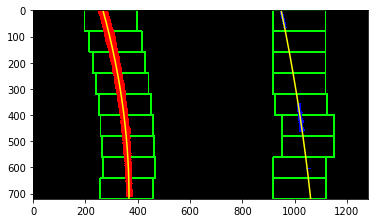

In [14]:
mtx, dist = calibrateCamera(useCalibrationCache=True)
    
# Perspective transform
testImage = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)

birdsEyeView = pipelineImageTransformation(testImage).astype(bool)
#imageUndistorted = undistortImage(testImage, mtx, dist, plotImages=False)
#imageSize = (imageUndistorted.shape[1], imageUndistorted.shape[0])
#src, dst, perspective_M, perspective_M_inv = getPerspectiveTransform(imageSize)

#imageTransformed = imageTransformation(imageUndistorted)
#imageSize = (imageTransformed.shape[1], imageTransformed.shape[0])
#birdsEyeView = warpImage2birdsEyeView(imageTransformed.astype(np.uint8), imageSize, perspective_M).astype(bool)

lineLeft = Line()
lineRight = Line()

#print("top_down_binary.shape = {}".format(birdsEyeView.shape))
outputImage = detectLaneLines(birdsEyeView, lineLeft, lineRight, plotImage=True)

print("left_fit: {}".format(lineLeft.getFit()))
print("right_fit: {}".format(lineRight.getFit()))   

## Step 4: Determine and display the curvature of the lane and vehicle position with respect to center 

In [15]:
def calculateAndWriteCurvatureRadius(image, configParams, lineLeft, lineRight):
    
    imageSize = image.shape
    leftCurveradius = lineLeft.getLaneLineCurvature(configParams, imageSize[0])
    rightCurveradius = lineRight.getLaneLineCurvature(configParams, imageSize[0])
    
    meanCurvature = np.mean([leftCurveradius, rightCurveradius])
   
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Curvature radius: {:.02f}m'.format(meanCurvature), (50, 50), font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    return

def caculateAndWriteLaneOffset(image, configParams, lineLeft, lineRight):
    
    lenY = image.shape[0]
    imgMidX = image.shape[1]/2
        
    ploty, leftFitx = lineLeft.getXY(lenY, useAverageFit=True)        
    xLeft = leftFitx[np.argmax(ploty)]
        
    ploty, rightFitx = lineRight.getXY(lenY, useAverageFit=True)        
    xRight = rightFitx[np.argmax(ploty)]
        
    laneMidX = xLeft + (xRight - xLeft)/2
    offset = configParams['x_meter_per_pixel'] * (imgMidX - laneMidX)
        
    text = ''
    font = cv2.FONT_HERSHEY_SIMPLEX
    if offset>0:
        text = 'Car {:.02f} m right of lane-center'.format(abs(offset))
    else:
        text = 'Car {:.02f} m left  of lane-center'.format(abs(offset))
          
    cv2.putText(image, text, (50, 100), font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    return

## Step 5: Project lane lines on a road/Warp  detected lane boundaries onto original image

In [16]:
def projectLaneLinesRoad(imageUndistored, birdsEyeImage, lineLeft, lineRight, perspective_M_inv):
    
    if False:  # For debugging: return binary with lane line search windows
        img_size = (birdsEyeImage.shape[1], birdsEyeImage.shape[0])
        warped = cv2.warpPerspective(birdsEyeImage, perspective_M_inv, img_size, flags=cv2.INTER_LINEAR)    
        return warped
    
    # Create an image to draw the lane area on
    colorWarp = np.zeros_like(imageUndistored).astype(np.uint8)
        
    ploty, leftFitx = lineLeft.getXY(imageUndistored.shape[0])
    ploty, rightFitx = lineRight.getXY(imageUndistored.shape[0])
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
    pts = np.hstack((ptsLeft, ptsRight))
    
    # Paint the lane area onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newWarp = cv2.warpPerspective(colorWarp, perspective_M_inv, 
                                  (colorWarp.shape[1], colorWarp.shape[0])) 
    
    # Combine the result with the original image
    imageResult = cv2.addWeighted(imageUndistored, 1, newWarp, 0.3, 0)
    
    # Lines need to be handled separately to make them visible in the final image
    # Draw lines on blank image
    linesWarp = np.zeros_like(imageUndistored).astype(np.uint8)    
    cv2.polylines(linesWarp, np.int32([ptsLeft]), isClosed=False, color=(255,0, 0), thickness=20)
    cv2.polylines(linesWarp, np.int32([ptsRight]), isClosed=False, color=(0,0, 255), thickness=20)
    newLinewarp = cv2.warpPerspective(linesWarp, perspective_M_inv, 
                                      (linesWarp.shape[1], linesWarp.shape[0])) 
    
    idx = np.any([newLinewarp][0], axis=2)
    
    # Copy the lines to the combined image
    imageResult[idx] = newLinewarp[idx]
            
    return imageResult

## Step 6: Apply project lane lines on test image


Using already available cached calibration results.



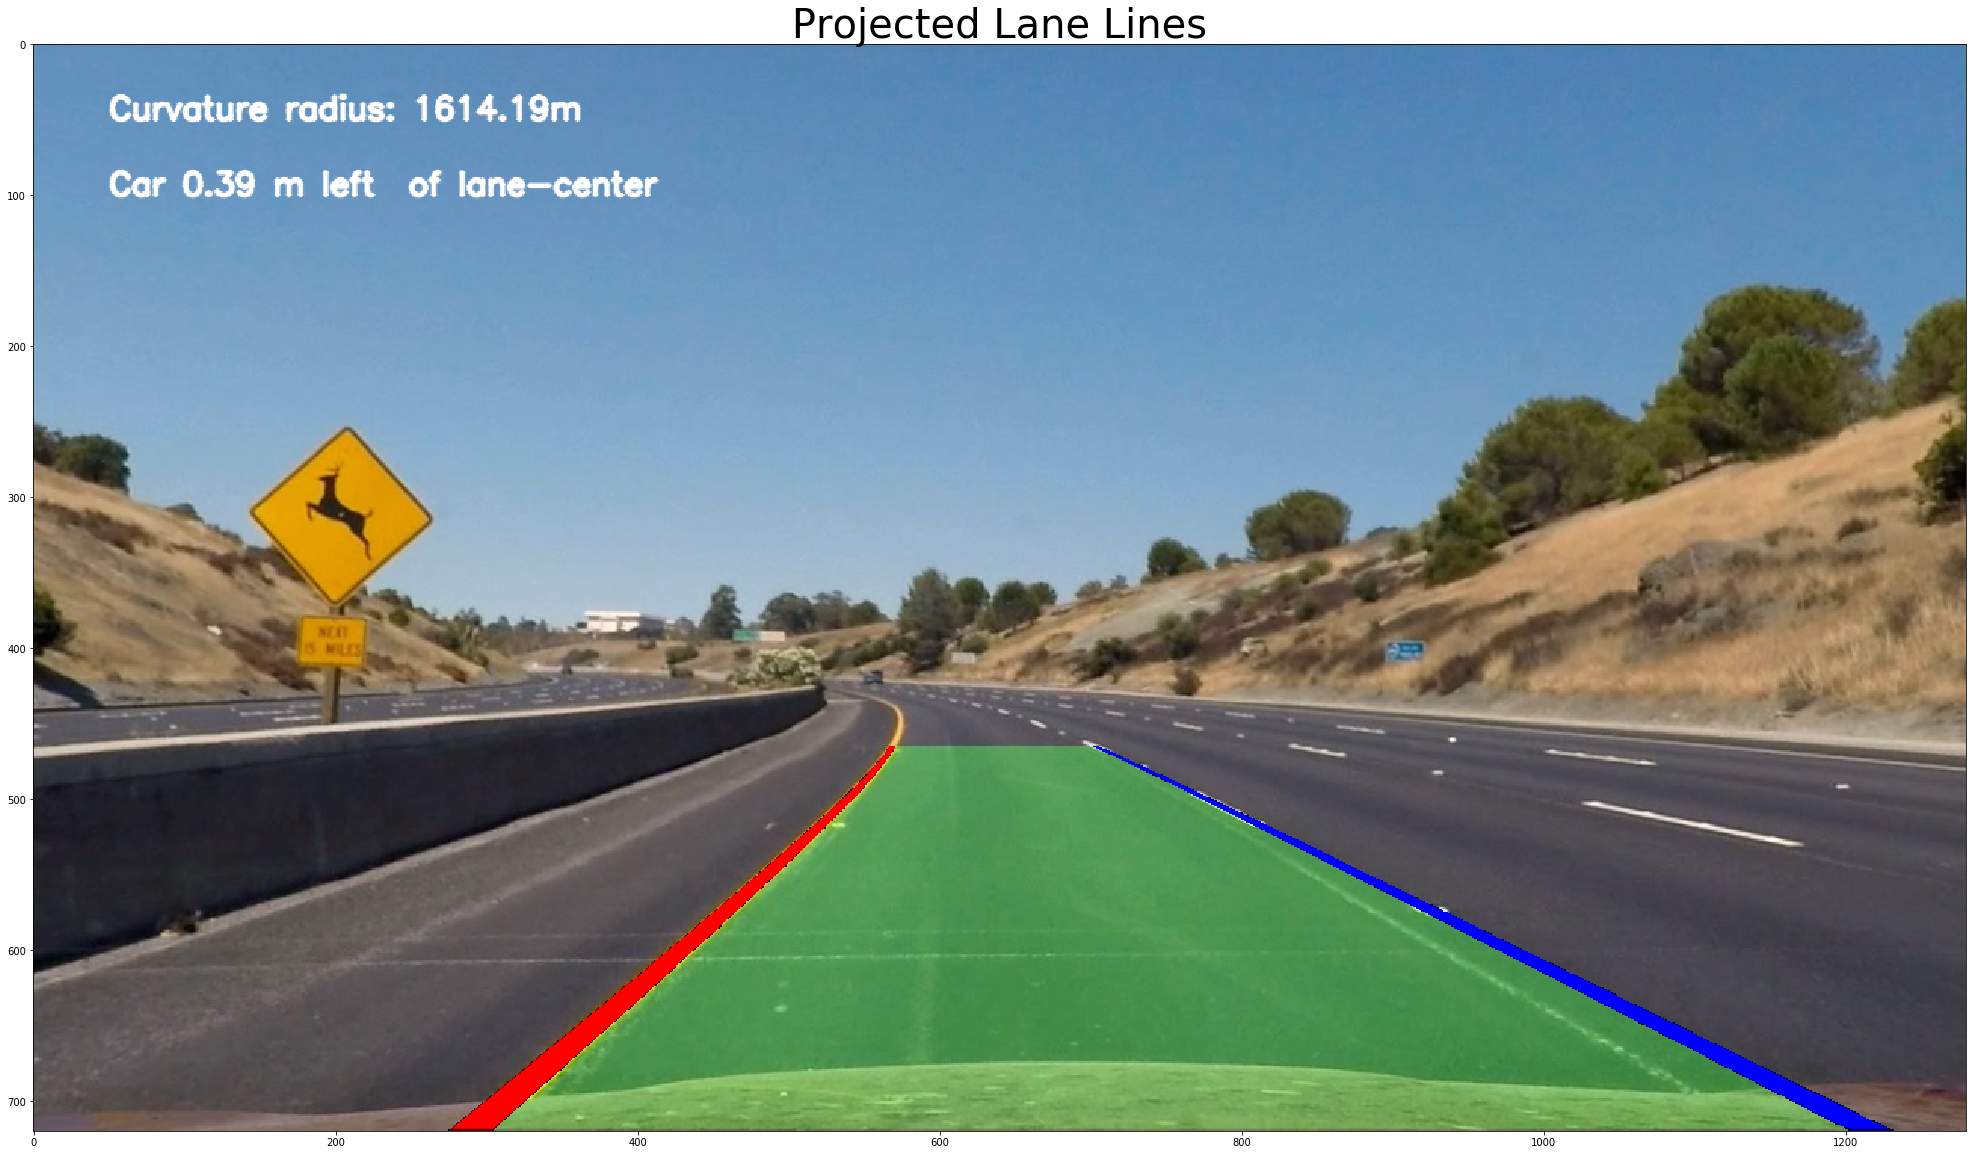

In [19]:
# Config parameters
configParams = {'x_margin': 100,
                'y_meter_per_pixel': 30.0/720,
                'x_meter_per_pixel': 3.7/700,
                }

mtx, dist = calibrateCamera(useCalibrationCache=True)
    
# Perspective transform
image = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)

birdsEyeImage = pipelineImageTransformation(testImage).astype(bool)
imageUndistored = undistortImage(image, mtx, dist, plotImages=False)
#imageSize = (imageUndistored.shape[1], imageUndistored.shape[0])
#src, dst, perspective_M, perspective_M_inv = getPerspectiveTransform(imageSize)
#imageTransformed = imageTransformation(imageUndistored)
    
#imageSize = (imageTransformed.shape[1], imageTransformed.shape[0])
#birdsEyeImage = warpImage2birdsEyeView(imageTransformed.astype(np.uint8), imageSize, perspective_M).astype(bool)

lineLeft = Line()
lineRight = Line()
    
outputImage = detectLaneLines(birdsEyeImage, lineLeft, lineRight, plotImage=False)  
imageLinesRoad = projectLaneLinesRoad(imageUndistored, outputImage, lineLeft, lineRight, perspective_M_inv)
calculateAndWriteCurvatureRadius(imageLinesRoad, configParams, lineLeft, lineRight)
caculateAndWriteLaneOffset(imageLinesRoad, configParams, lineLeft, lineRight)

fig, ax = plt.subplots(figsize=(40, 20))
ax.set_title('Projected Lane Lines', fontsize=40)
ax.imshow(imageLinesRoad) 